# Parameter Sweep over Inner Control Gains

In [1]:
; cd ..

/Users/rhenriquez/Github_Projects/InverterDynamicLinesModels


In [2]:
] activate

 Activating environment at `~/Github_Projects/InverterDynamicLinesModels/Project.toml`


In [3]:
] instantiate

In [4]:
using Plots
include(joinpath(pwd(), "InverterDynamicLinesModels", "InverterDynamicLinesModels.jl"))

In [5]:
using PowerSystems

In [6]:
# Load Data with PF solution from file
omib_sys = System(joinpath(pwd(), "data", "OMIB_inverter.json"));

┌ Info: Loaded time series from storage file existing=OMIB_inverter_time_series_storage.h5 new=/var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_zv0Bwc
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uydla/src/hdf5_time_series_storage.jl:72
┌ Warning: There are no Generator Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56
┌ Warning: There are no ElectricLoad Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56


## Voltage Inner Controller Sweep
Nominal parameters

In [8]:
kpv = 0.59
kiv = 736
kpc = 1.27
kic = 14.3;

## kpv effect: AC Static

In [9]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, ACStatic, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, ACStatic);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [10]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0; #Set p_ref to 1.0

In [11]:
N = 400
kpvrange = range(0.1*kpv,10*kpv, length=N);
res = Vector{Complex}(undef, N)
real_max_eig_vsm_acstatic = Vector{Float64}(undef, N) 
all_eigenvalues_vsm_acstatic = Matrix{Complex}(undef, N, 7)
p_fact_acstatic = Array{Float64}(undef, (N, 7, 7))
for (i, kpvval) in enumerate(kpvrange)
    parameter_values[24] = kpvval
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    res[i] = eig
    real_max_eig_vsm_acstatic[i] = real(eig)
    all_eigenvalues_vsm_acstatic[i, :] = ss_vsm.eigen_vals
    p_fact_acstatic[i, :, :] = round.(ss_vsm.participation_factors, digits=4)
end

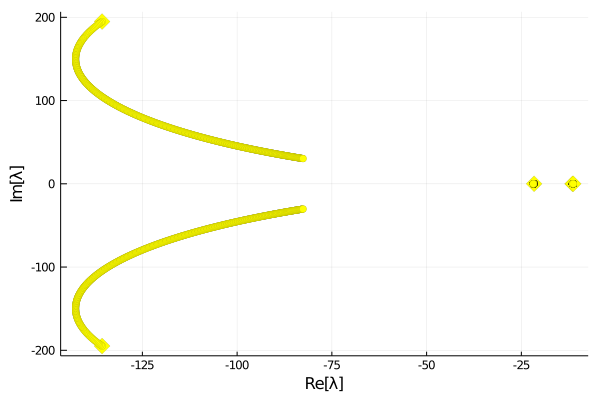

In [12]:
plt = scatter(real.(all_eigenvalues_vsm_acstatic[1,3:end]), imag.(all_eigenvalues_vsm_acstatic[1,3:end]), marker = (:diamond, 8),legend = :none, color=:yellow, markerstrokewidth = 0.1)
for i=1:N
    scatter!(real.(all_eigenvalues_vsm_acstatic[i,3:end]), imag.(all_eigenvalues_vsm_acstatic[i,3:end]), marker = 4,legend = :none, color=:yellow, markerstrokewidth = 0.1)
end
plot!(xlabel="Re[λ]")
plot!(ylabel="Im[λ]")
plt

## kiv effect: AC Static

In [13]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, ACStatic, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, ACStatic);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [14]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0; #Set p_ref to 1.0

In [15]:
N = 1000
kivrange = range(0.2*kiv,3*kiv, length=N);
res = Vector{Complex}(undef, N)
real_max_eig_vsm_acstatic = Vector{Float64}(undef, N) 
all_eigenvalues_vsm_acstatic = Matrix{Complex}(undef, N, 7)
p_fact_acstatic = Array{Float64}(undef, (N, 7, 7))
for (i, kivval) in enumerate(kivrange)
    parameter_values[25] = kivval
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    res[i] = eig
    real_max_eig_vsm_acstatic[i] = real(eig)
    all_eigenvalues_vsm_acstatic[i, :] = ss_vsm.eigen_vals
    p_fact_acstatic[i, :, :] = round.(ss_vsm.participation_factors, digits=4)
end

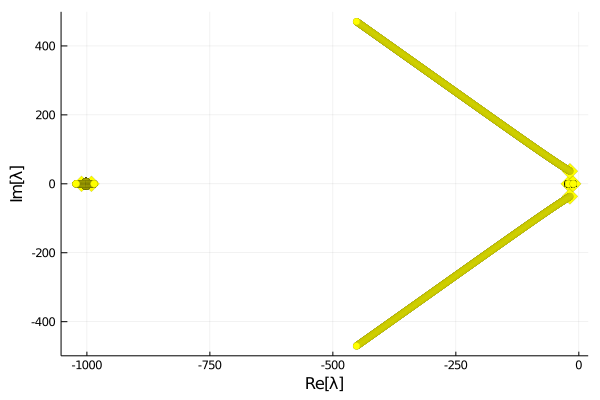

In [16]:
plt = scatter(real.(all_eigenvalues_vsm_acstatic[1,:]), imag.(all_eigenvalues_vsm_acstatic[1,:]), marker = (:diamond, 8),legend = :none, color=:yellow, markerstrokewidth = 0.1)
for i=1:N
    scatter!(real.(all_eigenvalues_vsm_acstatic[i,:]), imag.(all_eigenvalues_vsm_acstatic[i,:]), marker = 4,legend = :none, color=:yellow, markerstrokewidth = 0.1)
end
plot!(xlabel="Re[λ]")
plot!(ylabel="Im[λ]")
plt

## kpc effect: Three Models

In [17]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, DynamicLines, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, DynamicLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [18]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0; #Set p_ref to 1.0

In [19]:
N = 400
kpcrange = range(0.1*kpc,10*kpc, length=N);
res = Vector{Complex}(undef, N)
real_max_eig_vsm = Vector{Float64}(undef, N) 
all_eigenvalues_vsm = Matrix{Complex}(undef, N, 19)
p_fact = Array{Float64}(undef, (N, 19, 19))
for (i, kpcval) in enumerate(kpcrange)
    parameter_values[27] = kpcval
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    res[i] = eig
    real_max_eig_vsm[i] = real(eig)
    all_eigenvalues_vsm[i, :] = ss_vsm.eigen_vals
    p_fact[i, :, :] = round.(ss_vsm.participation_factors, digits=4)
end

In [20]:
#Eliminate Line+Filter Eigenvalues
index = falses(19)
index[13:17] .= true;

In [21]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, StaticLines, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, StaticLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [22]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0; #Set p_ref to 1.0

In [23]:
N = 400
kpcrange = range(0.1*kpc,10*kpc, length=N);
res = Vector{Complex}(undef, N)
real_max_eig_vsm_static = Vector{Float64}(undef, N) 
all_eigenvalues_vsm_static = Matrix{Complex}(undef, N, 13)
p_fact_static = Array{Float64}(undef, (N, 13, 13))
for (i, kpcval) in enumerate(kpcrange)
    parameter_values[27] = kpcval
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    res[i] = eig
    real_max_eig_vsm_static[i] = real(eig)
    all_eigenvalues_vsm_static[i, :] = ss_vsm.eigen_vals
    p_fact_static[i, :, :] = round.(ss_vsm.participation_factors, digits=4)
end

In [24]:
#Eliminate Filter Eigenvalues
index2 = falses(13)
index2[9:13] .= true;

In [25]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, ACStatic, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, ACStatic);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [26]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0; #Set p_ref to 1.0

In [27]:
N = 400
kpcrange = range(0.1*kpc,10*kpc, length=N);
res = Vector{Complex}(undef, N)
real_max_eig_vsm_acstatic = Vector{Float64}(undef, N) 
all_eigenvalues_vsm_acstatic = Matrix{Complex}(undef, N, 7)
p_fact_acstatic = Array{Float64}(undef, (N, 7, 7))
for (i, kpcval) in enumerate(kpcrange)
    parameter_values[27] = kpcval
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    res[i] = eig
    real_max_eig_vsm_acstatic[i] = real(eig)
    all_eigenvalues_vsm_acstatic[i, :] = ss_vsm.eigen_vals
    p_fact_acstatic[i, :, :] = round.(ss_vsm.participation_factors, digits=4)
end

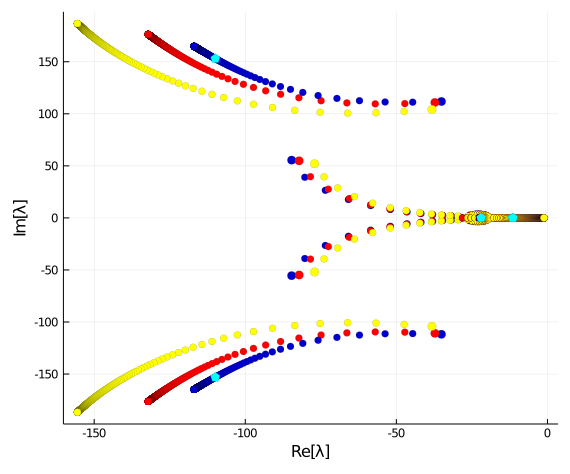

In [28]:
plt = scatter(real.(all_eigenvalues_vsm[1,index]), imag.(all_eigenvalues_vsm[1,index]), marker = 5,legend = :none, color=:blue3, markerstrokewidth = 0.1)
scatter!(real.(all_eigenvalues_vsm_static[1,index2]), imag.(all_eigenvalues_vsm_static[1,index2]), marker = 5,legend = :none, color=:red, markerstrokewidth = 0.1)
scatter!(real.(all_eigenvalues_vsm_acstatic[1,3:end]), imag.(all_eigenvalues_vsm_acstatic[1,3:end]), marker = 5,legend = :none, color=:yellow, markerstrokewidth = 0.1)
for i=2:N
    scatter!(real.(all_eigenvalues_vsm[i,index]), imag.(all_eigenvalues_vsm[i,index]), marker = 4,legend = :none, color=:blue3, markerstrokewidth = 0.1)
    scatter!(real.(all_eigenvalues_vsm_static[i,index2]), imag.(all_eigenvalues_vsm_static[i,index2]), marker = 4,legend = :none, color=:red, markerstrokewidth = 0.1)
    scatter!(real.(all_eigenvalues_vsm_acstatic[i,3:end]), imag.(all_eigenvalues_vsm_acstatic[i,3:end]), marker = 4,legend = :none, color=:yellow, markerstrokewidth = 0.1)
end
scatter!(real.(all_eigenvalues_vsm[Int(N/10)-3,index]), imag.(all_eigenvalues_vsm[Int(N/10)-3,index]), marker = (:pentagon, 5),legend = :none, color=:cyan, markerstrokewidth = 0.1)
plot!(size=(3*190,3*158.1))
#savefig(plt, "eigenplotkpc.pdf")
plot!(xlabel="Re[λ]")
plot!(ylabel="Im[λ]")
plt
#Blue for Dynamic Lines, Red for Algebraic Lines, Yellow for AC Static

### kic effect: AC Static

In [29]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, ACStatic, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, ACStatic);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm);

In [30]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0; #Set p_ref to 1.0

In [31]:
N = 1000
kicrange = range(0.1,50*kic, length=N);
res = Vector{Complex}(undef, N)
real_max_eig_vsm_acstatic = Vector{Float64}(undef, N) 
all_eigenvalues_vsm_acstatic = Matrix{Complex}(undef, N, 7)
p_fact_acstatic = Array{Float64}(undef, (N, 7, 7))
for (i, kicval) in enumerate(kicrange)
    parameter_values[28] = kicval
    M_vsm(parameter_values)
    jac_vsm(M_vsm)
    ss_vsm(M_vsm, jac_vsm)
    eig = ss_vsm.eigen_vals[end]
    res[i] = eig
    real_max_eig_vsm_acstatic[i] = real(eig)
    all_eigenvalues_vsm_acstatic[i, :] = ss_vsm.eigen_vals
    p_fact_acstatic[i, :, :] = round.(ss_vsm.participation_factors, digits=4)
end

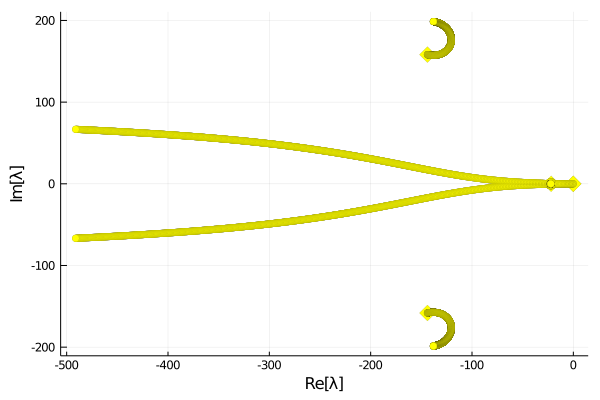

In [32]:
plt = scatter(real.(all_eigenvalues_vsm_acstatic[1,3:end]), imag.(all_eigenvalues_vsm_acstatic[1,3:end]), marker = (:diamond, 8),legend = :none, color=:yellow, markerstrokewidth = 0.1)
for i=1:N
    scatter!(real.(all_eigenvalues_vsm_acstatic[i,3:end]), imag.(all_eigenvalues_vsm_acstatic[i,3:end]), marker = 4,legend = :none, color=:yellow, markerstrokewidth = 0.1)
end
plot!(xlabel="Re[λ]")
plot!(ylabel="Im[λ]")
plt